In [1]:
####custom module####
import models
import preprocessing as pp
import lossfunction as loss
####################
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from glob import glob
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# Configure

In [2]:
seed = 42
EPOCH = 5
BATCH_SIZE = 32
lr = 1e-4
decay_rate = lr / EPOCH

modelinfo = {'Unet': (256, 256), 'ResUnet' : (256, 256),'Vgg16_Unet' :(224, 224), 'Vgg16_FCN' : (224, 224)}

modelname = 'ResUnet'
model = models.ResUnet()
target_size = modelinfo[modelname]

# Seed Fix

In [3]:
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
tf.random.set_seed(seed)

# Make result dir

In [4]:
os.makedirs(f'result/{modelname}', exist_ok=True)

# DataSet

In [5]:
# data path load
image_path = glob('Data/images/*.png')
mask_path = glob('Data/masks/*.png')

# train, val, test split
df = pd.DataFrame(data={'filename': image_path, 'mask': mask_path})
df_train , df_test = train_test_split(df, train_size=0.9, random_state=seed)
df_train , df_val = train_test_split(df_train, train_size=0.8, random_state=seed)

print('[train data]\n'+'image -',len(df_train['filename']),'mask -',len(df_train['mask']))
print('[validation data]\n'+'image -',len(df_val['filename']),'mask -',len(df_val['mask']))
print('[test data]\n'+'image -',len(df_test['filename']),'mask -',len(df_test['mask']))

[train data]
image - 1882 mask - 1882
[validation data]
image - 471 mask - 471
[test data]
image - 262 mask - 262


In [6]:
# dataset generating
args = dict(width_shift_range = 0.1,
            height_shift_range = 0.1,
            shear_range=0.1,
            rotation_range = 90,
            zoom_range = 0.2,
            horizontal_flip=True,
            fill_mode='nearest')
train_set = pp.dataset_generater(df_train,
                                 arg = args,
                                 image_col='filename',
                                 mask_col='mask',
                                 batch_size=BATCH_SIZE,
                                 target_size=target_size)
                                 
val_set   = pp.dataset_generater(df_val,
                                 image_col='filename',
                                 mask_col='mask',
                                 batch_size=BATCH_SIZE,
                                 target_size=target_size)

# 콜백 함수 정의

In [7]:
    # callback
savepath = f'result/{modelname}/{modelname}_checkpoint-epoch-{EPOCH}-batch-{BATCH_SIZE}-trial-001.h5'

checkpoint = ModelCheckpoint(savepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='auto'
                            )
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.5,
                             patience=2
                             )
earlystopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                             )

# 모델 생성

In [8]:
# model create & compile
model = model
model.summary()
print('Model Created!!')
model.compile(optimizer='adam', loss=loss.dice_coef_loss, metrics=["binary_accuracy", loss.iou, loss.dice_coef])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
# model fit
history = model.fit(train_set,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    validation_data = val_set,
                    validation_steps=len(df_val) / BATCH_SIZE,
                    epochs=EPOCH,
                    callbacks = [checkpoint, reduceLR]
                    )

Found 1882 validated image filenames.
Found 1882 validated image filenames.
Epoch 1/5
59/58 [==============================] - ETA: 0s - loss: -0.5594 - binary_accuracy: 0.8887 - iou: 0.3970 - dice_coef: 0.5597Found 471 validated image filenames.
Found 471 validated image filenames.
58/58 [==============================] - 84s 1s/step - loss: -0.5594 - binary_accuracy: 0.8887 - iou: 0.3970 - dice_coef: 0.5597 - val_loss: -0.2368 - val_binary_accuracy: 0.3850 - val_iou: 0.1345 - val_dice_coef: 0.2370

Epoch 00001: val_loss improved from inf to -0.23679, saving model to result/ResUnet\ResUnet_checkpoint-epoch-5-batch-32-trial-001.h5


C:\Users\Ung\Anaconda3\envs\tengpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
58/58 [==============================] - 70s 1s/step - loss: -0.7176 - binary_accuracy: 0.9486 - iou: 0.5609 - dice_coef: 0.7177 - val_loss: -0.2462 - val_binary_accuracy: 0.4114 - val_iou: 0.1408 - val_dice_coef: 0.2466

Epoch 00002: val_loss improved from -0.23679 to -0.24623, saving model to result/ResUnet\ResUnet_checkpoint-epoch-5-batch-32-trial-001.h5
Epoch 3/5
58/58 [==============================] - 70s 1s/step - loss: -0.7610 - binary_accuracy: 0.9552 - iou: 0.6183 - dice_coef: 0.7610 - val_loss: -0.4518 - val_binary_accuracy: 0.8953 - val_iou: 0.2924 - val_dice_coef: 0.4518

Epoch 00003: val_loss improved from -0.24623 to -0.45181, saving model to result/ResUnet\ResUnet_checkpoint-epoch-5-batch-32-trial-001.h5
Epoch 4/5
58/58 [==============================] - 71s 1s/step - loss: -0.7971 - binary_accuracy: 0.9620 - iou: 0.6666 - dice_coef: 0.7971 - val_loss: -0.6214 - val_binary_accuracy: 0.9133 - val_iou: 0.4515 - val_dice_coef: 0.6216

Epoch 00004: val_loss improv

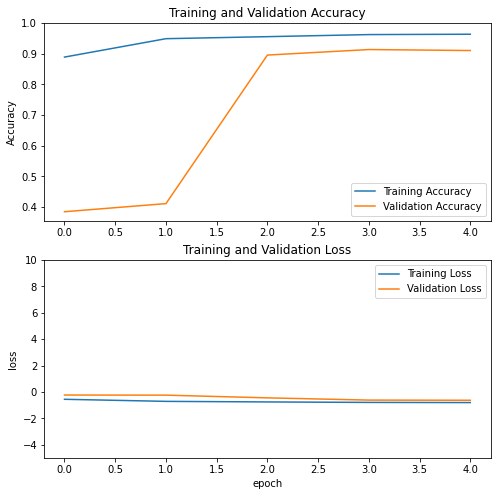

In [13]:
#Plotting 
dice_train = history.history['binary_accuracy']
dice_test = history.history['val_binary_accuracy']

iou_train = history.history['iou']
iou_test = history.history['val_iou']

loss_train = history.history['loss']
loss_test = history.history['val_loss']

plt.figure(figsize=(8, 8)) 

plt.subplot(2, 1, 1) 
plt.plot(dice_train, label='Training Accuracy') 
plt.plot(dice_test, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.ylabel('Accuracy') 
plt.ylim([min(plt.ylim()),1]) 
plt.title('Training and Validation Accuracy') 

plt.subplot(2, 1, 2) 
plt.plot(loss_train, label='Training Loss') 
plt.plot(loss_test, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.ylabel('loss') 
plt.ylim([-5,10]) 
plt.title('Training and Validation Loss') 
plt.xlabel('epoch') 
plt.show()

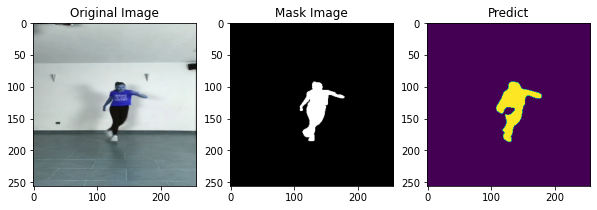

In [15]:
img = cv2.imread(df_test['filename'].iloc[5])
img = cv2.resize(img , target_size)
img = img / 255
img = img[np.newaxis, :, :, :]
mask = cv2.imread(df_test['mask'].iloc[5])
mask = cv2.resize(mask , target_size)
pred=model.predict(img)
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img))
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(np.squeeze(mask))
plt.title('Mask Image')
plt.subplot(1,3,3)
plt.imshow(np.squeeze(pred) > .5)
plt.title('Predict')
plt.show()